Attempting to load data from TX_daily.csv
Starting data preprocessing...
Loaded 2691 rows of data
Date column processed
Return calculated
Momentum calculated
Moving averages calculated
RSI calculated
MACD calculated
Preprocessing complete. Final dataframe has 2667 rows
Total data points: 2667
Training data points: 2133
Testing data points: 534
Starting DDQN training...

Starting episode 1
  Step 0/1000


C:\Users\hught\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 1 completed. Total Reward: -0.23, Epsilon: 0.01

Starting episode 2
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 2 completed. Total Reward: -0.07, Epsilon: 0.01

Starting episode 3
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 3 completed. Total Reward: 0.03, Epsilon: 0.01

Starting episode 4
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 4 completed. Total Reward: -0.03, Epsilon: 0.01

Starting episode 5
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
 

  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 36 completed. Total Reward: -0.21, Epsilon: 0.01

Starting episode 37
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 37 completed. Total Reward: -0.22, Epsilon: 0.01

Starting episode 38
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 38 completed. Total Reward: -0.30, Epsilon: 0.01

Starting episode 39
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 400/1000
  Step 500/1000
  Step 600/1000
  Step 700/1000
  Step 800/1000
  Step 900/1000
Episode 39 completed. Total Reward: -0.30, Epsilon: 0.01

Starting episode 40
  Step 0/1000
  Step 100/1000
  Step 200/1000
  Step 300/1000
  Step 4

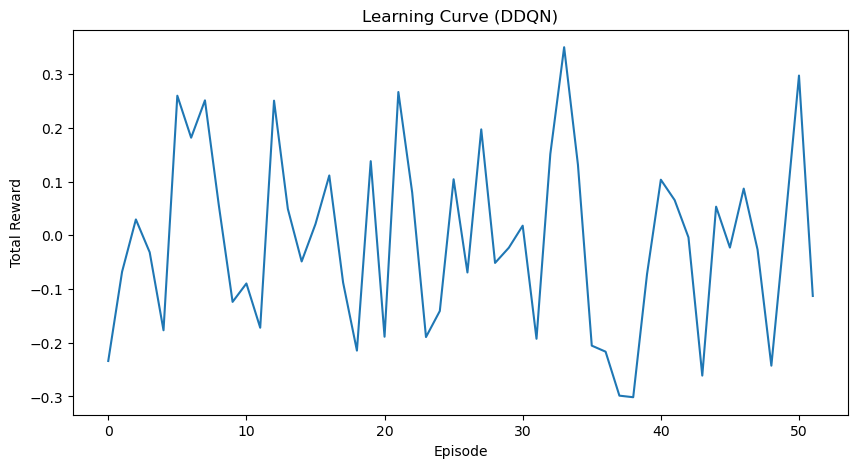

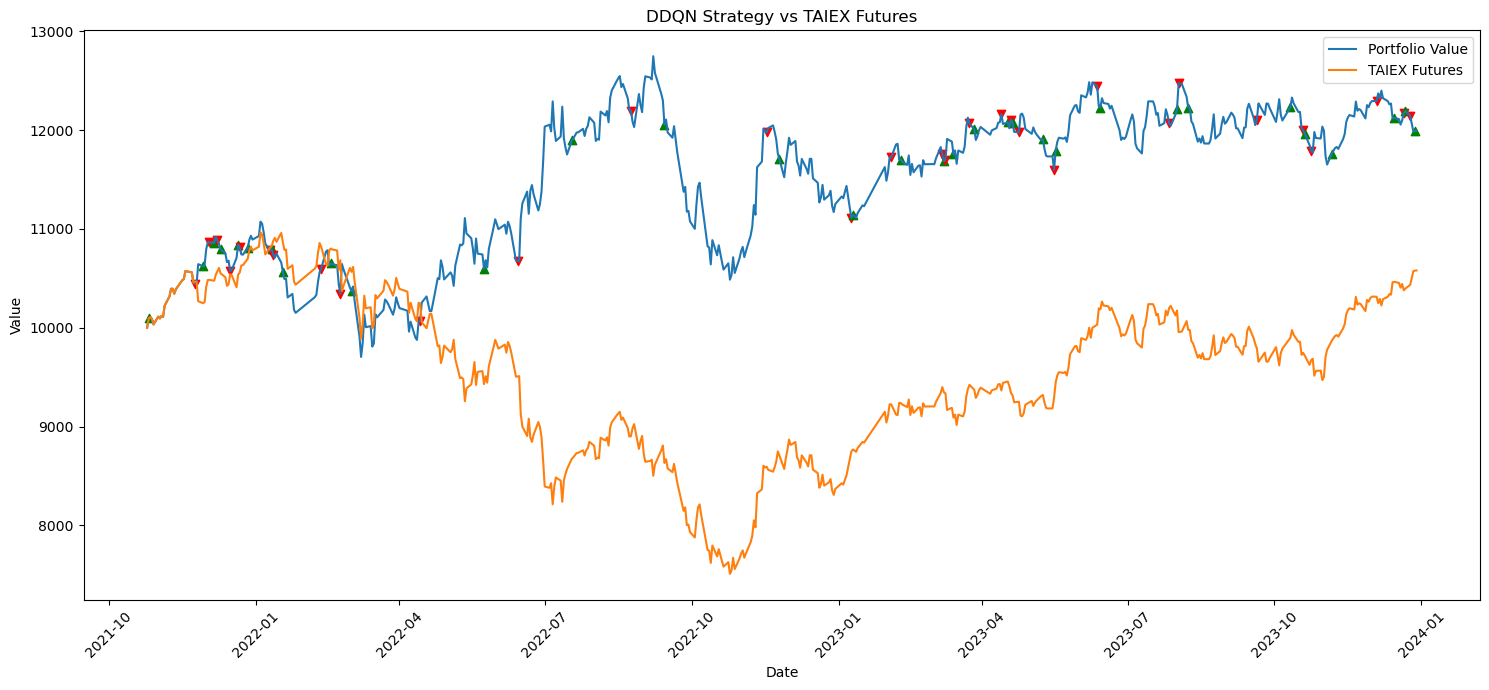


Performance Metrics:
Total Return (%): 19.9478
Annualized Return (%): 8.9801
Sharpe Ratio: 0.5918
Max Drawdown (%): 17.7406
Win Rate (%): 48.5929


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

class DDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=10000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self._build_model()
        self.target_model = clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())

    def _build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i]
        self.target_model.set_weights(target_weights)

def preprocess_data(file_path):
    print("Starting data preprocessing...")
    df = pd.read_csv(file_path, thousands=',')
    print(f"Loaded {len(df)} rows of data")
    
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    df.set_index('Date', inplace=True)
    print("Date column processed")
    
    df['Return'] = df['Close'].pct_change()
    print("Return calculated")
    
    df['Momentum'] = df['Close'] - df['Close'].shift(10)
    print("Momentum calculated")
    
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA20_slope'] = (df['MA20'] - df['MA20'].shift(5)) / df['MA20'].shift(5)
    print("Moving averages calculated")
    
    df['RSI'] = calculate_rsi(df['Close'])
    print("RSI calculated")
    
    df['MACD'], df['Signal'] = calculate_macd(df['Close'])
    print("MACD calculated")
    
    df = df.dropna()
    print(f"Preprocessing complete. Final dataframe has {len(df)} rows")
    return df

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def get_state(data):
    return np.array([
        data['Return'],
        data['Momentum'],
        data['MA20_slope'],
        data['RSI'],
        data['MACD'],
        data['Signal']
    ])

def calculate_reward(action, return_value, position):
    if action == 0:  # Buy
        return return_value if position != "Long" else 0
    elif action == 1:  # Sell
        return -return_value if position != "Short" else 0
    else:  # Hold
        return 0 if position == "Cash" else return_value if position == "Long" else -return_value

def run_ddqn(data, episodes=500, batch_size=32, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001, max_steps=1000):
    print("Starting DDQN training...")
    state_size = 6
    action_size = 3
    agent = DDQNAgent(state_size, action_size, learning_rate, gamma, epsilon, epsilon_min, epsilon_decay, batch_size=batch_size)
    
    rewards_history = []
    
    for episode in range(episodes):
        print(f"\nStarting episode {episode + 1}")
        state = get_state(data.iloc[0])
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        position = "Cash"
        
        for step in range(min(len(data)-1, max_steps)):
            if step % 100 == 0:
                print(f"  Step {step}/{min(len(data)-1, max_steps)}")
            action = agent.act(state)
            next_state = get_state(data.iloc[step+1])
            next_state = np.reshape(next_state, [1, state_size])
            return_value = data.iloc[step+1]['Return']
            
            if action == 0 and position != "Long":
                position = "Long"
            elif action == 1 and position != "Short":
                position = "Short"
            
            reward = calculate_reward(action, return_value, position)
            total_reward += reward
            
            done = (step == min(len(data)-2, max_steps-1))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
            
            if done:
                break
        
        agent.target_train()
        rewards_history.append(total_reward)
        
        print(f"Episode {episode + 1} completed. Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
        
        if episode > 50 and np.mean(rewards_history[-10:]) < np.mean(rewards_history[-50:-10]):
            print("Early stopping due to no improvement")
            break
    
    print("DDQN training completed")
    return agent, rewards_history

def evaluate_ddqn_strategy(agent, data, initial_capital=10000):
    state_size = 6
    position = "Cash"
    portfolio_value = initial_capital
    portfolio_values = [portfolio_value]
    trades = []
    
    for i in range(1, len(data)):
        state = get_state(data.iloc[i-1])
        state = np.reshape(state, [1, state_size])
        action = agent.act(state)
        return_value = data.iloc[i]['Return']
        
        if action == 0 and position != "Long":  # Buy
            position = "Long"
            trades.append(("Buy", data.index[i], data.iloc[i]['Close']))
        elif action == 1 and position != "Short":  # Sell
            position = "Short"
            trades.append(("Sell", data.index[i], data.iloc[i]['Close']))
        
        if position == "Long":
            portfolio_value *= (1 + return_value)
        elif position == "Short":
            portfolio_value *= (1 - return_value)
        
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, trades

def calculate_performance_metrics(portfolio_values, benchmark_values):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    benchmark_returns = pd.Series(benchmark_values).pct_change().dropna()
    
    total_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0] * 100
    annualized_return = (1 + total_return/100) ** (252 / len(returns)) - 1
    
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    
    max_drawdown = np.max(1 - portfolio_values / np.maximum.accumulate(portfolio_values))
    
    win_rate = (returns > 0).mean() * 100
    
    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": annualized_return * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown * 100,
        "Win Rate (%)": win_rate
    }

# Main program
if __name__ == "__main__":
    file_path = "TX_daily.csv"  # 确保这个文件路径是正确的
    print(f"Attempting to load data from {file_path}")
    data = preprocess_data(file_path)

    if data is not None:
        print(f"Total data points: {len(data)}")
        
        # Split the dataset into training and testing sets (80:20)
        split_index = int(len(data) * 0.8)
        train_data = data[:split_index]
        test_data = data[split_index:]
        
        print(f"Training data points: {len(train_data)}")
        print(f"Testing data points: {len(test_data)}")

        # Train the DDQN agent
        start_time = time.time()
        trained_agent, rewards_history = run_ddqn(train_data, episodes=500, batch_size=16, max_steps=1000)
        end_time = time.time()
        print(f"Training time: {end_time - start_time:.2f} seconds")

        # Plot learning curve
        plt.figure(figsize=(10, 5))
        plt.plot(rewards_history)
        plt.title('Learning Curve (DDQN)')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

        # Evaluate the model on the test set
        portfolio_values, trades = evaluate_ddqn_strategy(trained_agent, test_data)

        # Plot results
        plt.figure(figsize=(15, 7))
        plt.plot(test_data.index, portfolio_values, label='Portfolio Value')
        plt.plot(test_data.index, test_data['Close'] / test_data['Close'].iloc[0] * portfolio_values[0], label='TAIEX Futures')
        
        for trade in trades:
            if trade[0] == "Buy":
                plt.scatter(trade[1], portfolio_values[test_data.index.get_loc(trade[1])], color='g', marker='^')
            elif trade[0] == "Sell":
                plt.scatter(trade[1], portfolio_values[test_data.index.get_loc(trade[1])], color='r', marker='v')
        
        plt.title('DDQN Strategy vs TAIEX Futures')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Calculate performance metrics
        benchmark_values = test_data['Close'] / test_data['Close'].iloc[0] * portfolio_values[0]
        performance_metrics = calculate_performance_metrics(portfolio_values, benchmark_values)

        print("\nPerformance Metrics:")
        for key, value in performance_metrics.items():
            print(f"{key}: {value:.4f}")
    else:
        print("Failed to read or preprocess the data.")